<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

❕ Add `kaggle.json` API token to files before starting

In [1]:
import os, subprocess

def run(cmd):
    """Helper to execute shell commands with logging."""
    print(f"▶ {cmd}")
    subprocess.run(cmd, shell=True, check=True)

# --- Kaggle setup ---
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
    run("mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")

# --- Kaggle data download (only if missing) ---
if not os.path.exists("data/train"):
    run("kaggle competitions download -c aml-competition -p data")
    run("unzip -qo data/aml-competition.zip -d data")

# --- Clone repositories ---
if not os.path.exists("challenge"):
    run("git clone https://github.com/Mamiglia/challenge.git")
if not os.path.exists("CrossFlow"):
    run("git clone https://github.com/qihao067/CrossFlow.git")

# --- Install dependencies ---
!pip install -q torch torchvision torchaudio
!pip install -q openai-clip scikit-learn opencv-python torchdiffeq \
    beautifulsoup4 open_clip_torch scikit-image cython matplotlib accelerate \
    absl-py ml_collections einops wandb ftfy transformers timm tensorboard pycocotools

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import sys, random, logging
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import copy
import torch.optim as optim
from IPython.display import clear_output

# Extend path to local repositories
sys.path.extend(["CrossFlow", "challenge/src"])

# Project imports
from common.utils import load_data, prepare_train_data, generate_submission
from eval.metrics import mrr, recall_at_k, ndcg
from diffusion.flow_matching import ClipLoss
from challenge.src.eval import visualize_retrieval

# Clear existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [3]:
# Configuration dictionary
CFG = {
    "MODEL_PATH": "models/basic-flow-matching.pth",
    "SEED": 42,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # --- Model Arhitecture ---
    "LATENT_DIM": 1024,
    "HIDDEN_DIM": 2048,

    # --- Base Training (Flow Matching) ---
    "EPOCHS": 20,
    "BATCH_SIZE": 256,
    "LR": 1e-3,
    "STEPS_PER_EPOCH": 100,

    # --- ReFlow Training ---
    "REFLOW_EPOCHS": 10,
    "REFLOW_LR": 3e-4,
    "REFLOW_NEW_POINTS_EVERY": 5, # steps
    "REFLOW_INTEGRATION_STEPS": 8, # n_steps for teacher integration

    # --- Inference ---
    "INFERENCE_INTEGRATION_STEPS": 8,
}

In [4]:
def set_seed(seed=42):
  """Ensure deterministic reproducibility."""
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

set_seed(CFG["SEED"])
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Model

In [5]:
class VelocityNet(nn.Module):
    """Predicts velocity (dX/dt) given position and time scalar (concatenated)."""
    def __init__(self, input_dim=None, hidden_dim=None):
        input_dim = input_dim or CFG["LATENT_DIM"]
        hidden_dim = hidden_dim or CFG["HIDDEN_DIM"]
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2    = nn.Linear(hidden_dim, hidden_dim)
        self.fc3    = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        # concat input with time
        t = t.expand(x.size(0), 1)
        x = torch.cat([x, t], dim=1)
        x = F.gelu(self.fc_in(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        return self.fc_out(x)


In [6]:
# Integration functions

@torch.no_grad()
def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return current_points + velocity * dt

@torch.no_grad()
def rk4_step(f, # function that takes (y,t) and returns dy/dt, i.e. velocity
             y, # current location
             t, # current t value
             dt, # requested time step size
             ):
    k1 =  f(y, t)
    k2 =  f(y + dt*k1/2, t + dt/2)
    k3 =  f(y + dt*k2/2, t + dt/2)
    k4 =  f(y + dt*k3, t + dt)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

@torch.no_grad()
def integrate_path(model, initial_points, step_fn=fwd_euler_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    current_points = initial_points.clone()
    ts =  torch.linspace(0,1,n_steps, device=device)
    if warp_fn: ts = warp_fn(ts)
    if save_trajectories: trajectories = [current_points]
    for i in range(len(ts)-1):
        current_points = step_fn(model, current_points, ts[i], ts[i+1]-ts[i])
        if save_trajectories: trajectories.append(current_points)
    if save_trajectories: return current_points, torch.stack(trajectories).cpu()
    return current_points


In [7]:
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle.
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s<0 or s>1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t
    if dt:                           # warped time-step requested; use derivative
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s)
    return tw

# Viz Helpers

In [8]:
# color palette
wong_amber = [230/255, 159/255, 0/255]
wong_cyan = [86/255, 180/255, 233/255]
wong_green = [0/255, 158/255, 115/255]
wong_yellow = [240/255, 228/255, 66/255]
wong_navy = [0/255, 114/255, 178/255]
wong_red = [213/255, 94/255, 0/255]
wong_pink = [204/255, 121/255, 167/255]

source_color = wong_navy
target_color = wong_red
pred_color = wong_green
line_color = wong_yellow

plt.style.use("default")

def plot_distributions(dist1, dist2, title1="Source", title2="Target"):
    """Project two embedding sets into 2D with PCA and plot side-by-side."""
    X1_2d = PCA(n_components=2).fit_transform(dist1.cpu())
    X2_2d = PCA(n_components=2).fit_transform(dist2.cpu())
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X1_2d[:, 0], X1_2d[:, 1], color=source_color, alpha=0.6, s=8)
    ax2.scatter(X2_2d[:, 0], X2_2d[:, 1], color=target_color, alpha=0.6, s=8)
    ax1.set_title(title1); ax2.set_title(title2)
    for ax in (ax1, ax2):
        ax.set_aspect("equal"); ax.axis("off")
    plt.tight_layout(); plt.show(); plt.close()

def viz(val_points, target_samples, trained_model, size=20, alpha=0.6, n_steps=100, warp_fn=None):
    """Generate samples via integrate_path and visualize trajectories + endpoints."""
    device = next(trained_model.parameters()).device
    gen, trajectories = integrate_path(trained_model, val_points.to(device), n_steps=n_steps, warp_fn=warp_fn, save_trajectories=True)
    n_viz = min(30, trajectories.shape[1])
    data_list = [val_points.cpu(), gen.cpu(), target_samples.cpu()]
    fig, ax = plt.subplots(1, 4, figsize=(14, 3.2))
    labels = ['Initial', 'Generated', 'Target', 'Trajectories']
    colors = [source_color, pred_color, target_color]
    # compute global bounds
    cat = torch.cat([d for d in data_list], dim=0)
    global_max = float(torch.max(torch.abs(cat)).cpu().item()) * 1.05 + 1e-6
    for i in range(3):
        ax[i].set_title(labels[i])
        ax[i].set_xlim([-global_max, global_max]); ax[i].set_ylim([-global_max, global_max])
        ax[i].scatter(data_list[i][:, 0], data_list[i][:, 1], s=size, alpha=alpha, color=colors[i])
    # trajectories panel
    ax[3].set_title(labels[3])
    for j in range(n_viz):
        path = trajectories[:, j]
        ax[3].plot(path[:, 0], path[:, 1], '-', color=line_color, linewidth=1, alpha=0.9)
    start = trajectories[0, :n_viz]; end = trajectories[-1, :n_viz]
    ax[3].scatter(start[:, 0], start[:, 1], color=source_color, s=size, label='start')
    ax[3].scatter(end[:, 0], end[:, 1], color=pred_color, s=size, label='end')
    ax[3].legend(); plt.tight_layout(); plt.show(); plt.close()


# Data

In [9]:
"""
Prepare training and validation sets, and cache full gallery for MRR computation.
"""
train_data = load_data("data/train/train/train.npz")
X, y, label = prepare_train_data(train_data)

perm = torch.randperm(len(X))
split_idx = int(0.9 * len(X))
mask = torch.zeros(len(X), dtype=torch.bool)
mask[perm[:split_idx]] = True

X_train, X_val = X[mask], X[~mask]
y_train, y_val = y[mask], y[~mask]
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=CFG["BATCH_SIZE"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=CFG["BATCH_SIZE"])

img_mask = label[~mask].sum(dim=0) > 0

(125000,)
Train data: 125000 captions, 125000 images


Plotting original data distributions (before projection):


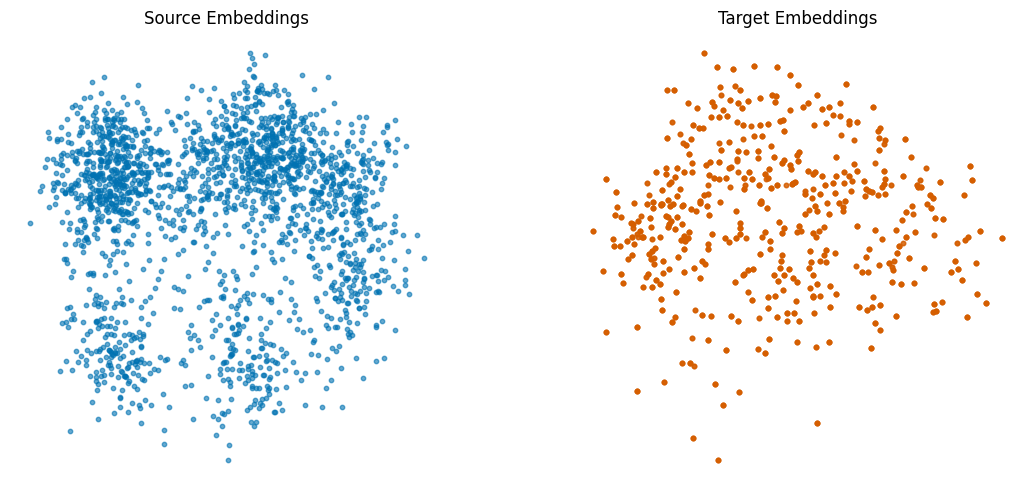

Original Source shape: torch.Size([112500, 1024]), Original Target shape: torch.Size([112500, 1536])
Projected Val shapes (for viz only): torch.Size([12500, 1024]), torch.Size([12500, 1024])


In [10]:
# Projection to shared latent space (linear mappings)
text_dim = X_train.shape[1]
image_dim = y_train.shape[1]
LATENT_DIM = CFG["LATENT_DIM"]

proj_text = nn.Linear(text_dim, LATENT_DIM).to(CFG["DEVICE"])
proj_img  = nn.Linear(image_dim, LATENT_DIM).to(CFG["DEVICE"])
proj_out = nn.Linear(LATENT_DIM, image_dim).to(CFG["DEVICE"])


# --- Visualization Helpers ---
# We pre-project the validation set *once* for visualization.
# Note: These are based on the *untrained* weights.
# The training loop does *not* use this static data.

@torch.no_grad()
def project_val_data(X, Y):
    Xp = proj_text(X.to(CFG["DEVICE"]))
    Yp = proj_img(Y.to(CFG["DEVICE"]))
    return Xp, Yp

X_val_proj, y_val_proj = project_val_data(X_val, y_val)


def create_val_source_data(n=None):
    """Helper to get validation data for visualization."""
    idx = torch.randint(0, X_val_proj.shape[0], (n,))
    return X_val_proj[idx]

def plot_distributions(dist1, dist2, title1="Source Embeddings", title2="Target Embeddings"):
    """Project embeddings to 2D (PCA) and visualize, even if dims differ"""
    plt.close('all')

    # project each separately (they can have different dimensions)
    X1_2d = PCA(n_components=2).fit_transform(dist1.cpu())
    X2_2d = PCA(n_components=2).fit_transform(dist2.cpu())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X1_2d[:, 0], X1_2d[:, 1], color=source_color, alpha=0.6, s=10)
    ax2.scatter(X2_2d[:, 0], X2_2d[:, 1], color=target_color, alpha=0.6, s=10)
    ax1.set_title(title1)
    ax2.set_title(title2)
    for ax in [ax1, ax2]:
        ax.set_aspect("equal")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot the *original* data distributions (before projection)
print("Plotting original data distributions (before projection):")
plot_distributions(X_train[:2000], y_train[:2000])
print(f"Original Source shape: {X_train.shape}, Original Target shape: {y_train.shape}")
print(f"Projected Val shapes (for viz only): {X_val_proj.shape}, {y_val_proj.shape}")

# Training

In [11]:
# Training

def train_model(model, n_epochs, lr, batch_size, status_every=1, viz_every=1, warp_fn=None):
    device = next(model.parameters()).device
    optimizer = optim.Adam(
        list(model.parameters())
        + list(proj_text.parameters())
        + list(proj_img.parameters()),
        lr=lr
    )
    loss_fn = nn.MSELoss()
    model.to(device)
    step = 0
    n_steps = CFG["STEPS_PER_EPOCH"]

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(range(n_steps), desc=f"[Train] Epoch {epoch+1}/{n_epochs}", leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()

            idx = torch.randint(0, X_train.shape[0], (batch_size,))
            source_samples = proj_text(X_train[idx].to(device))
            target_samples = proj_img(y_train[idx].to(device))

            t = torch.rand(source_samples.size(0), 1).to(device)  # random times for traning
            if warp_fn: t = warp_fn(t)    # time warp is good for coverage but not as helpful for training as it is during integration/sampling
            interpolated_samples = source_samples * (1 - t) + target_samples * t
            line_directions = target_samples - source_samples

            drift = model(interpolated_samples, t)
            loss = loss_fn(drift, line_directions)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / n_steps
        print(f"\n> Epoch {epoch+1}: Avg Loss = {avg_loss:.6f}")

        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            with torch.no_grad():
                # 1. Get new validation source points
                val_idx_source = torch.randint(0, X_val.shape[0], (1000,))
                val_points = proj_text(X_val[val_idx_source].to(device))

                # 2. Get new validation target points
                val_idx_target = torch.randint(0, y_val.shape[0], (batch_size,))
                viz_targets = proj_img(y_val[val_idx_target].to(device))
            viz(val_points, viz_targets[:val_points.shape[0]], model)
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()

    return model

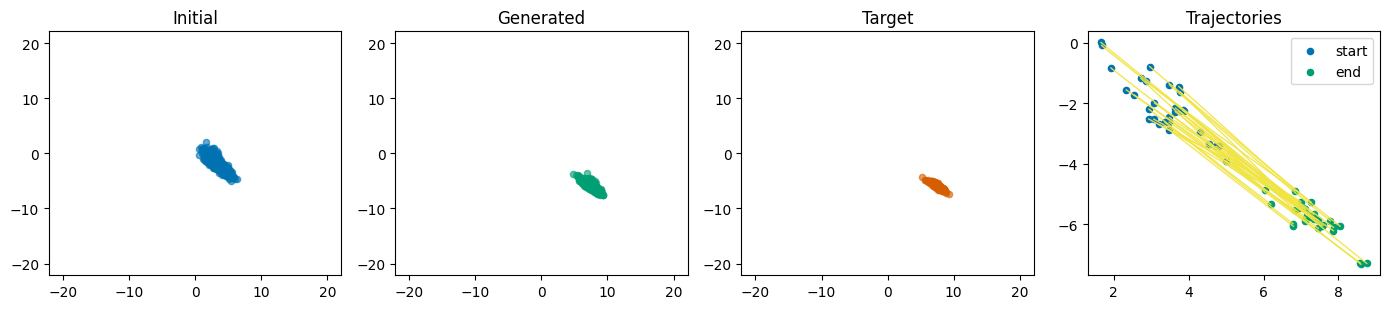

In [12]:
"""
Build, initialize, and train the selected model.
"""
model = VelocityNet().to(CFG["DEVICE"])
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(
    model,
    n_epochs=CFG["EPOCHS"],
    lr=CFG["LR"],
    batch_size=CFG["BATCH_SIZE"]
)

## ReFlow

In [13]:
## ReFlow

def train_reflow_model(model, pretrained_model, n_epochs, lr, batch_size,
                          status_every=1, viz_every=5, # in epochs
                          warp_fn=warp_time,
                          step_fn=rk4_step, # rk4 so we get high-quality outputs while reflowing
                          ):

    optimizer = optim.Adam(
        list(model.parameters()) + list(proj_out.parameters()),
        lr=lr,
        weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    loss_fn = nn.MSELoss()
    step = 0
    n_steps = CFG["STEPS_PER_EPOCH"]
    device = next(model.parameters()).device

    for epoch in range(n_epochs):
        model.train()
        total_flow_loss = 0
        total_recons_loss = 0
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()

            if (step - 1) % CFG["REFLOW_NEW_POINTS_EVERY"] == 0:
                idx = torch.randint(0, X_train.shape[0], (batch_size,))
                gt_image_emb = y_train[idx].to(device)

                # Project source text embeddings (detach, as proj_text is now frozen)
                source_samples = proj_text(X_train[idx].to(device)).detach()

                if pretrained_model:   # HERE is the ReFlow operation...
                    target_samples = integrate_path(
                        pretrained_model,
                        source_samples,
                        step_fn=rk4_step,
                        warp_fn=warp_time,
                        n_steps=CFG["REFLOW_INTEGRATION_STEPS"],
                        save_trajectories=False
                    ).detach() # Detach teacher's output
                else:
                    # Fallback if no teacher: use original proj_img targets
                    target_samples = proj_img(gt_image_emb).detach()

            t = torch.rand(source_samples.size(0), 1).to(device) # random times for training
            if warp_fn: t = warp_fn(t)

            interpolated_samples = source_samples * (1 - t) + target_samples * t
            v = model(interpolated_samples, t)
            line_directions = target_samples - source_samples

            # 1. Flow loss (trains the student velocity model)
            loss_flow = loss_fn(v, line_directions)

            # 2. Reconstruction loss (trains proj_out)
            decoded_img = proj_out(target_samples)
            loss_recons = loss_fn(decoded_img, gt_image_emb)

            loss = loss_flow + 0.5 * loss_recons

            loss.backward()
            optimizer.step()
            total_flow_loss += loss_flow.item()
            total_recons_loss += loss_recons.item()

        avg_flow_loss = total_flow_loss / n_steps
        avg_recons_loss = total_recons_loss / n_steps
        print(f"\n> Epoch {epoch+1}: Avg Flow Loss = {avg_flow_loss:.6f}, Avg Recons Loss = {avg_recons_loss:.6f}")

        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots

            with torch.no_grad():
                # 1. Get new validation source points
                val_idx_source = torch.randint(0, X_val.shape[0], (1000,))
                val_points_viz = proj_text(X_val[val_idx_source].to(device))

                # 2. Get new validation target points
                val_idx_target = torch.randint(0, y_val.shape[0], (batch_size,))
                viz_targets = proj_img(y_val[val_idx_target].to(device))

            viz(val_points_viz, viz_targets[:val_points_viz.shape[0]], model)
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()

        scheduler.step()

    return model

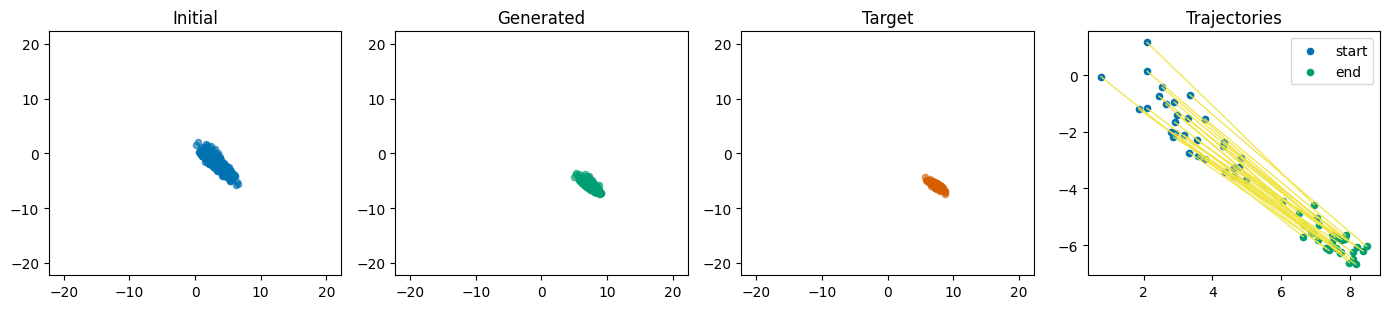

In [14]:
"""
Run ReFlow training by creating a frozen teacher and a trainable student.
"""
import copy

teacher = copy.deepcopy(model)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# Ensure projection layers are frozen for ReFlow (teacher & student should share frozen proj_text/proj_img)
for p in proj_text.parameters(): p.requires_grad = False
for p in proj_img.parameters():  p.requires_grad = False

student = copy.deepcopy(teacher)
# But the student must be trainable (unfreeze student params)
for p in student.parameters(): p.requires_grad = True

# Ensure proj_out is trainable (we want to learn decoding)
for p in proj_out.parameters(): p.requires_grad = True

reflow_student = train_reflow_model(
    student,
    pretrained_model=teacher,
    n_epochs=CFG["REFLOW_EPOCHS"],
    lr=CFG["REFLOW_LR"],
    batch_size=CFG["BATCH_SIZE"]
)

reflow_model = reflow_student

## Evaluation

### Visualize

In [15]:
val_caption_text = train_data['captions/text'][~mask]
val_text_embd = X_val
val_img_file = train_data['images/names'][img_mask]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_mask])
val_label = np.nonzero(train_data['captions/label'][~mask][:,img_mask])[1]

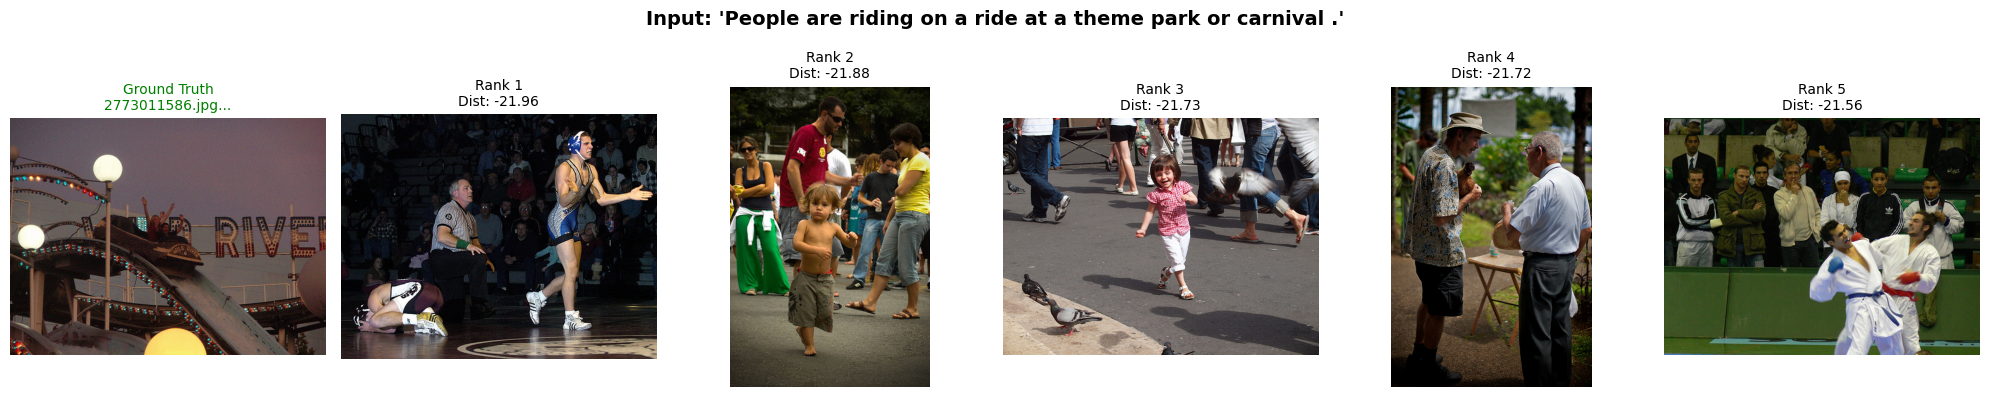

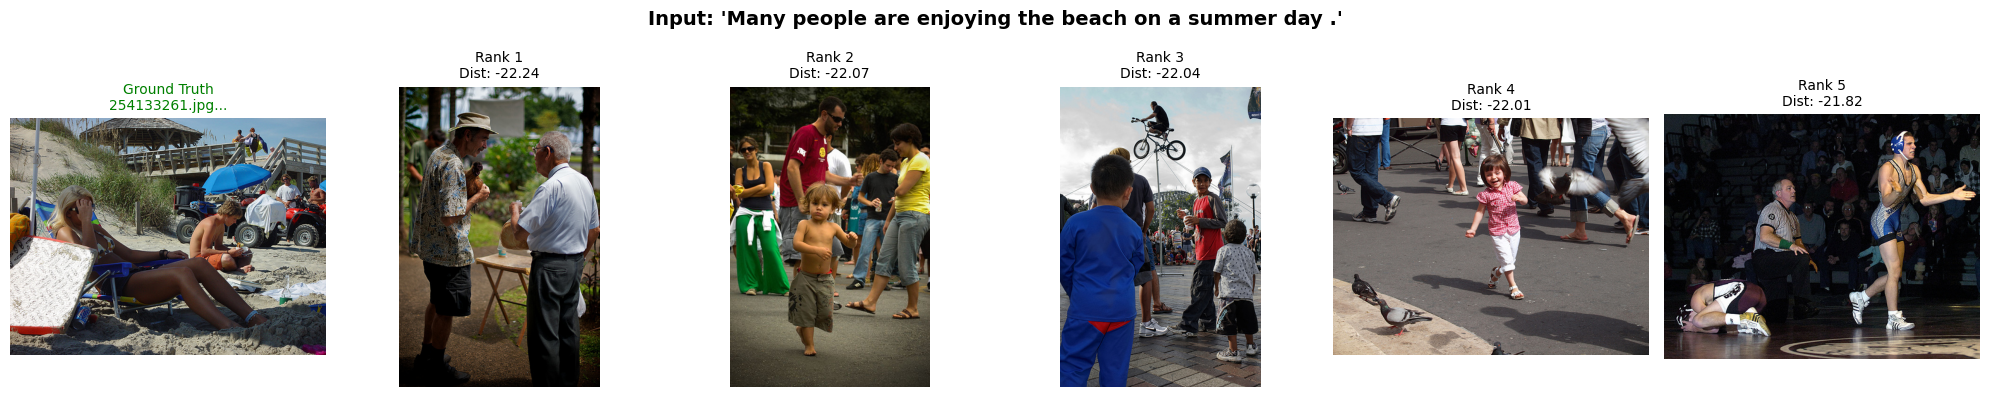

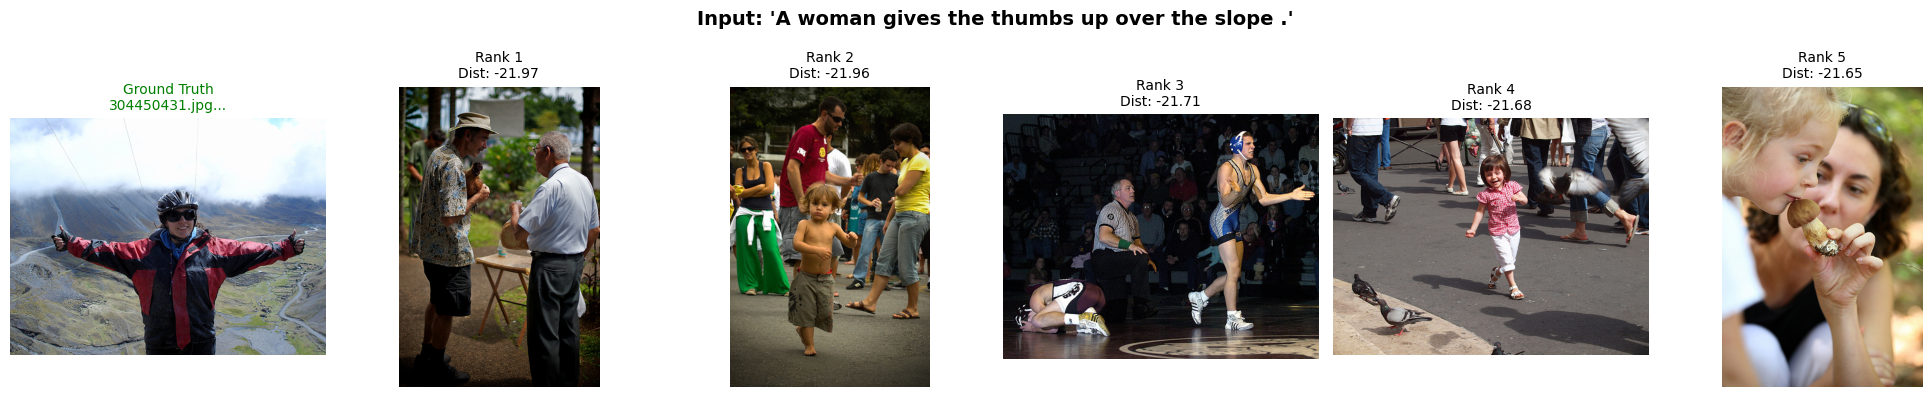

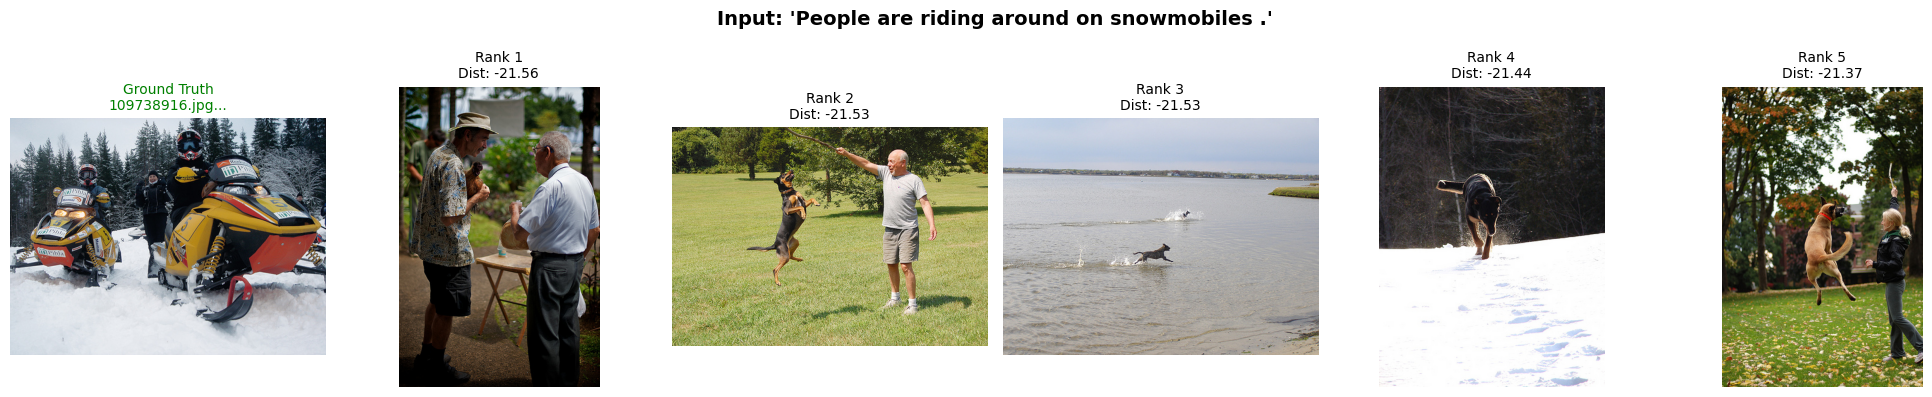

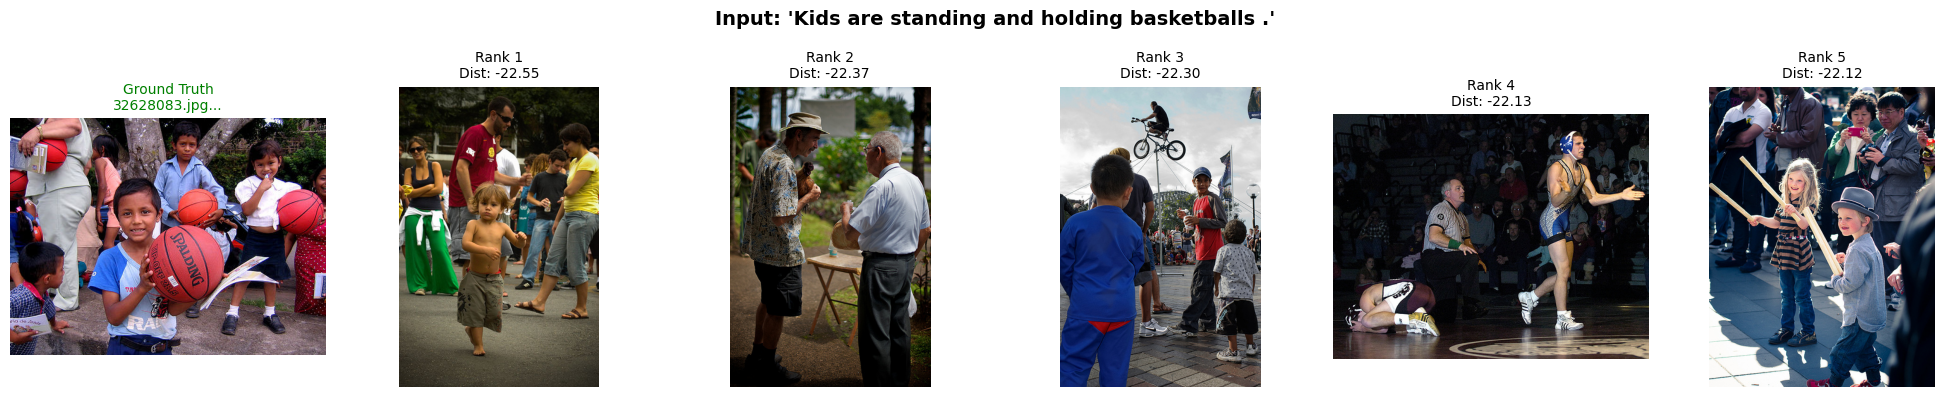

In [16]:
@torch.no_grad()
def predict_image_embeddings(model, captions):
    """Project captions → latent → integrate → decode → normalized image embeddings."""
    latent = proj_text(captions.to(CFG["DEVICE"]))
    latent_end = integrate_path(
        model,
        latent,
        n_steps=CFG["INFERENCE_INTEGRATION_STEPS"]
    )
    decoded = proj_out(latent_end.to(CFG["DEVICE"]))
    return F.normalize(decoded, dim=-1).cpu()

# ---- Evaluation ----
proj_text.eval(); proj_out.eval(); reflow_model.eval()

for i in range(5):
    idx = np.random.randint(0, len(X_val))
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]  # use precomputed val_label

    with torch.no_grad():
        pred_embds = predict_image_embeddings(reflow_model, X_val[idx].unsqueeze(0))

    visualize_retrieval(
        pred_embds,
        gt_index,
        val_img_file,
        caption_text,
        val_img_embd,  # use precomputed val_img_embd
        k=5,
        dataset_path="data/train/train"
    )

## Submission

In [18]:
"""
Generate predictions for the test set and export the Kaggle submission file.
"""

# ---- Submission ----
test_data = load_data("data/test/test/test.clean.npz")
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()
pred_embds = predict_image_embeddings(reflow_model, test_embds)

generate_submission(test_data['captions/ids'], pred_embds, 'submission-basic-flow.csv')
logging.info(f"Submission saved | Model saved to {CFG['MODEL_PATH']}")

Generating submission file...
✓ Saved submission to submission-basic-flow.csv
Submission saved | Model saved to models/basic-flow-matching.pth
